Get dataframe

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres
0,0HZk0QsXPhMNAWNDR3rYE8,0.4700,0.364,0.378,0.0,7,0.3390,-7.381,0,0.0331,89.918,3,0.366,a-cappella
1,6tkbKjaHRL2ZG5wtmHzXgn,0.7640,0.556,0.412,0.0,7,0.0902,-10.224,1,0.0992,84.778,4,0.811,a-cappella
2,4z8sz6E4YyFuEkv5o7IJni,0.3020,0.497,0.312,0.0,11,0.0968,-9.088,0,0.0269,105.036,4,0.177,a-cappella
3,6XamqE26MOlAoXs1LZr8AU,0.3080,0.674,0.517,0.0,2,0.0896,-7.147,1,0.0555,120.127,4,0.476,a-cappella
4,5glU2EWqa5hpYqGPboSNjV,0.0243,0.419,0.817,0.0,2,0.2510,-4.704,1,0.0468,78.107,4,0.317,a-cappella


Heatmap to discover low correlation features

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.000000,-0.421916,-0.784065,0.323526,-0.104296,-0.640456,-0.066722,-0.223505,-0.305464
danceability,-0.421916,1.000000,0.391948,-0.299802,0.001278,0.425349,0.228910,0.033849,0.533337
energy,-0.784065,0.391948,1.000000,-0.357118,0.194279,0.794030,0.085639,0.264318,0.448613
instrumentalness,0.323526,-0.299802,-0.357118,1.000000,-0.121329,-0.533992,-0.152479,-0.113529,-0.237620
liveness,-0.104296,0.001278,0.194279,-0.121329,1.000000,0.146228,0.129099,0.046717,0.069993
loudness,-0.640456,0.425349,0.794030,-0.533992,0.146228,1.000000,0.055282,0.222895,0.323491
speechiness,-0.066722,0.228910,0.085639,-0.152479,0.129099,0.055282,1.000000,0.040668,0.063647
tempo,-0.223505,0.033849,0.264318,-0.113529,0.046717,0.222895,0.040668,1.000000,0.153970
valence,-0.305464,0.533337,0.448613,-0.237620,0.069993,0.323491,0.063647,0.153970,1.000000


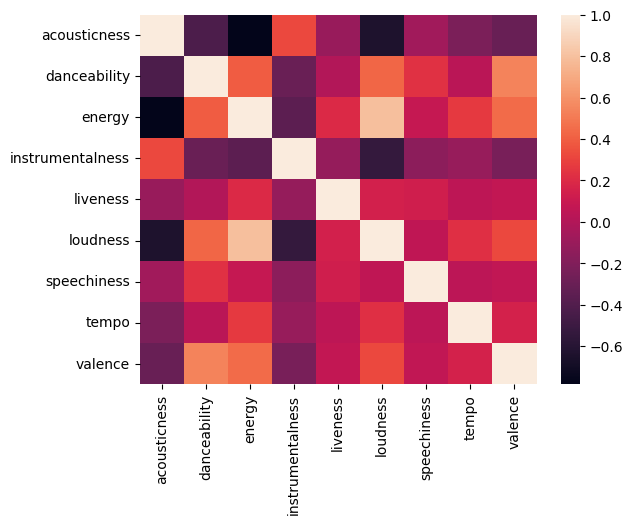

In [113]:
import seaborn as sns
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
dataplot = sns.heatmap(df[features].corr())
# List correlation values
df[features].corr()
# plt.show()

Investigate the relationship between energy and loudness since it has the highest correlation

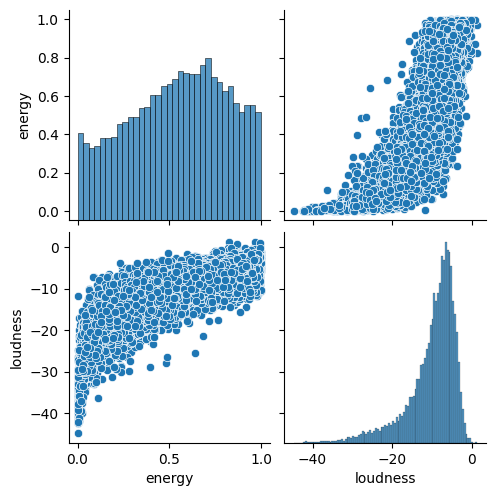

In [109]:
invest_features = ['energy', 'loudness']
data_scatter = sns.pairplot(df[invest_features])
plt.show()

Box plot for features

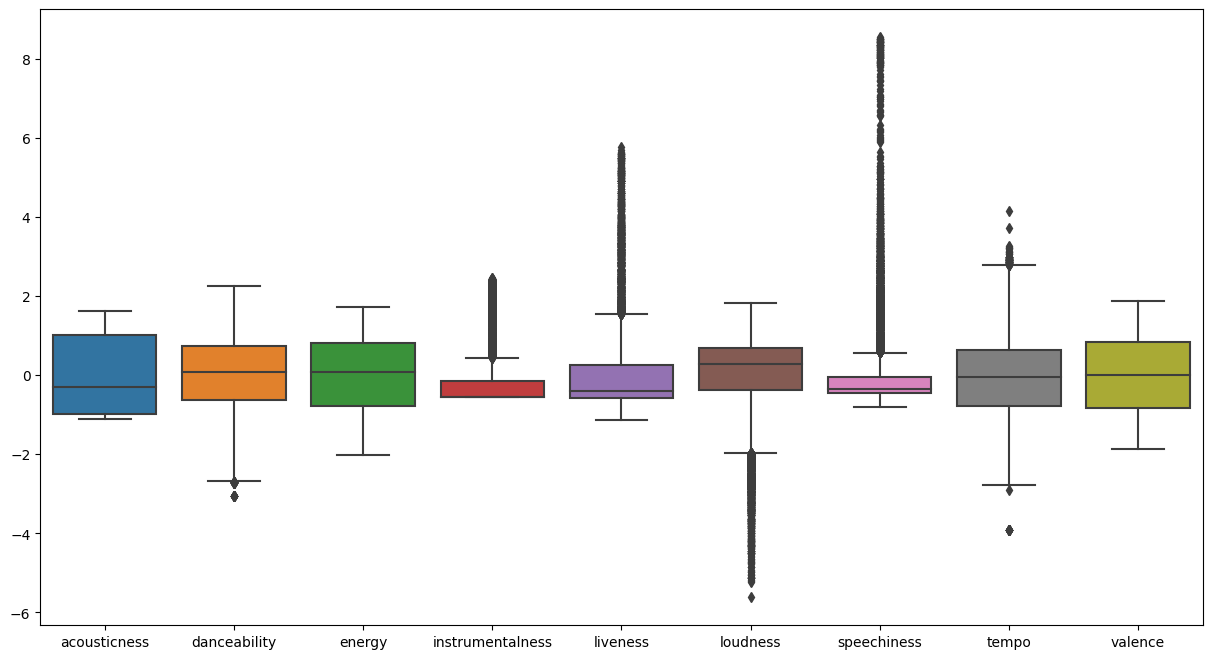

In [110]:

from sklearn.preprocessing import StandardScaler
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=features)
sns.boxplot(data=x)
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Remove outliers

In [111]:
# Remove any data with tempo = 0
no_out_df = df[df['tempo'] != 0]
# Remove the first and the last column
no_out_df = no_out_df.iloc[:, 1:-1]
no_out_df.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.4700,0.364,0.378,0.0,7,0.3390,-7.381,0,0.0331,89.918,3,0.366
1,0.7640,0.556,0.412,0.0,7,0.0902,-10.224,1,0.0992,84.778,4,0.811
2,0.3020,0.497,0.312,0.0,11,0.0968,-9.088,0,0.0269,105.036,4,0.177
3,0.3080,0.674,0.517,0.0,2,0.0896,-7.147,1,0.0555,120.127,4,0.476
4,0.0243,0.419,0.817,0.0,2,0.2510,-4.704,1,0.0468,78.107,4,0.317


Clustering with K-Prototypes

In [114]:
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=5, verbose=1, n_jobs=4, init='Cao')
clusters = kproto.fit_predict(no_out_df, categorical=[5,8,11])
# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 3, iteration: 1/100, moves: 2810, ncost: 2296780.0929581057
Run: 1, iteration: 1/100, moves: 3152, ncost: 2642095.452131464
Run: 2, iteration: 1/100, moves: 3604, ncost: 2800332.4017302105
Run: 4, iteration: 1/100, moves: 6204, ncost: 2316347.284720157
Run: 3, iteration: 2/100, moves: 1286, ncost: 2235145.5515116714
Run: 1, iteration: 2/100, moves: 1180, ncost: 2594034.056935686
Run: 2, iteration: 2/100, moves: 3398, ncost: 2476744.7657758663
Run: 4, iteration: 2/100, moves: 1753, ncost: 2246546.06836671
Run: 3, iteration: 3/100, moves: 866, ncost: 2210611.5683949417
Run: 1, iteration: 3/100,